# Import des librairies nécessaires

N'hesitez-pas à ajouter plus de librairie si nécessaire.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from qiskit import Aer, QuantumCircuit, transpile, assemble, Aer, execute
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.quantum_info import SparsePauliOp

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Import des données

In [2]:
data = pd.read_csv("dataset/challenge_dataset.csv")

X = data.drop("label", axis=1).values
y = data["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_scaled = X_scaled[:, :3]
print(X_scaled[0].shape[0])
X_scaled_test = scaler.transform(X_test)
X_scaled_test = X_scaled_test[:, :3]

3


# À faire

La cellule qui suit donne un simple exemple non fonctionnel de ce qui peut devenir un classificateur binaire quantique. Vous pouvez modifier ce code comme il vous plait. Inspirez-vous de ce qui a été présenté par Jean-Fred en matinée.

À l'issu du défi, vous devez avoir un `NeuralNetworkClassifier` que vous devez sauvegarder à l'aide de la fonction `save`.

Pour tester votre classificateur, nous allons utiliser la fonction `load` puis la fonction `score` comme démontré à la toute fin de ce notebook.

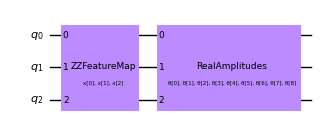

In [24]:
sampler = Sampler()

l2_loss = L2Loss()

nb_qubits = X_scaled[0].shape[0]
nb_layers = 2

ansatz = RealAmplitudes(nb_qubits, reps=nb_layers)
feature_map = ZZFeatureMap(nb_qubits)
qc = feature_map.compose(ansatz)

x0 = np.random.random(ansatz.num_parameters)

objective_func_vals = []
validation_loss = []
stop = False

# qc.append(feature_map, qc.qubits)
# qc.append(ansatz, qc.qubits)

def callback_fct(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)
    print(objective_func_vals)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.plot(range(len(validation_loss), validation_loss)
    plt.show()


def parite(x):
    return "{:b}".format(x).count("1") % 2

sampler = Sampler()
qnn = SamplerQNN(
    circuit=qc,
    sampler=sampler,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parite,
    output_shape=2
)


#estimator = Estimator()
# observable = SparsePauliOp('IIIIIIIIZ')
#observable = SparsePauliOp('IIY')
#qnn = EstimatorQNN(
#    estimator=estimator,
#    circuit=qc,
#    input_params=feature_map.parameters,
#    weight_params=ansatz.parameters,
#    observables=observable
#)


nnc = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),
    loss=l2_loss,
    initial_point=x0,
    callback=callback_graph)

qc.draw('mpl', scale=0.5)
# nnc.fit(X, y)

In [28]:
predictions = nnc.predict(X_scaled)
scores = nnc.score(X_scaled_test, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [25, 75]

In [19]:
predictions.mean()
#predictions.shape

0.6933333333333334

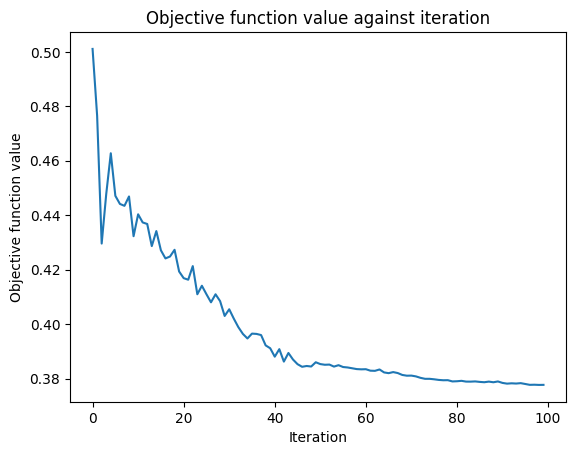

In [25]:
nnc.fit(X_scaled, y_train)

# Sauvegarder votre classificateur

In [ ]:
nnc.save('nnc')

# Lisez et testez votre classificateur

In [ ]:
def grade(file_name, X, y):
  nnc = NeuralNetworkClassifier.load(file_name)
  nnc.score(X, y)